# Deep learning volatility

**Abstract:**

*We present a consistent neural network based calibration method for a number of volatility models-including the rough volatility family-that performs the calibration task within a few milliseconds for the full implied volatility surface.*

*The aim of neural networks in this work is an off-line approximation of complex pricing functions, which are difficult to represent or time-consuming to evaluate by other means. We highlight how this perspective opens new horizons for quantitative modelling: The calibration bottleneck posed by a slow pricing of derivative contracts is lifted. This brings several model families (such as rough volatility models) within the scope of applicability in industry practice. As customary for machine learning, the form in which information from available data is extracted and stored is crucial for network performance. With this in mind we discuss how our approach addresses the usual challenges of machine learning solutions in a financial context (availability of training data, interpretability of results for regulators, control over generalisation errors). We present specific architectures for price approximation and calibration and optimize these with respect different objectives regarding accuracy, speed and robustness. We also find that including the intermediate step of learning pricing functions of (classical or rough) models before calibration significantly improves network performance compared to direct calibration to data.*

**Reference:** *Horvath, B., Muguruza, A. and Tomas, M., 2019. Deep Learning Volatility. Available at SSRN 3322085.*

Throughout this presentation, we will use the rough Bergomi model as an example for the methodology, insisting on the fact it is model independent. We will also use a fixed grid of points to represent the implied volatility surface.

In [1]:
import os
os.chdir("..\Data")

In [2]:
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
f = gzip.GzipFile('HestonTrainSet.txt.gz', "r")
dat=np.load(f)
xx=dat[:,:5]
yy=dat[:,5:]
print(xx.shape)
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

(12000, 5)


# Step 1: Data Generation


## **Inputs:** 
###  1. $\rho$ spot-vol correlation,
###  2. $\nu$ vol of vol
###  3. $\theta$ long term vol
###  4. $\kappa$ speed of mean reversion 
###  5. $\xi_{0}$ forward variance curve
    
    
## **Outputs:**
### Implied volatility surface (11x8=88 points)

# Scaling:

# Model Parameters $\theta\to scale(\theta)\in[-1,1]$
## $scale(\theta^i)=\frac{2\theta^i-(\theta^i_{max}-\theta^i_{min})}{\theta^i_{max}-\theta^i_{min}},\quad i \in |\Theta|$

# Implied volatilities
## $$scale(\sigma_{BS}^{i,j})=\frac{\sigma_{BS}^{i,j}-\mathbb{E}[\sigma_{BS}^{i,j}]}{std(\sigma_{BS}^{i,j})},\quad i\in\text{Maturities},\; j\in \text{Strikes}$$

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    yy, xx, test_size=0.15, random_state=42)
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
scale2=  StandardScaler()
y_train_transform = scale.fit_transform(y_train)
y_test_transform = scale.transform(y_test)
x_train_transform = scale2.fit_transform(X_train)
x_test_transform = scale2.transform(X_test)

In [4]:
def xtransform(X_train,X_test):
    return [scale2.transform(X_train),scale2.transform(X_test)]

    
[x_train_transform,x_test_transform]=xtransform(X_train,X_test)

def xinversetransform(x):
    return scale2.inverse_transform(x)

In [5]:
ub=[0.04,-0.1,1.0,0.2,10.0]
lb=[0.0001,-0.95,0.01,0.01,1]
def myscale(x):
    res=np.zeros(5)
    for i in range(5):
        res[i]=(x[i] - (ub[i] + lb[i])*0.5) * 2 / (ub[i] - lb[i])
        
    return res
def myinverse(x):
    res=np.zeros(5)
    for i in range(5):
        res[i]=x[i]*(ub[i] - lb[i]) *0.5 + (ub[i] + lb[i])*0.5
        
    return res

In [6]:
y_train_transform = np.array([myscale(y) for y in y_train])
y_test_transform = np.array([myscale(y) for y in y_test])

# Create the Neural Network

In [7]:
import keras
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
keras.backend.set_floatx('float64')


input1 = keras.layers.Input(shape=(5,))
x1 = keras.layers.Dense(30,activation = 'elu')(input1)
x2=keras.layers.Dense(30,activation = 'elu')(x1) 
x3=keras.layers.Dense(30,activation = 'elu')(x2) 


x4=keras.layers.Dense(88,activation = 'linear')(x3)


modelGEN = keras.models.Model(inputs=input1, outputs=x4)
modelGEN.summary()

Using TensorFlow backend.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                180       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_3 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_4 (Dense)              (None, 88)                2728      
Total params: 4,768
Trainable params: 4,768
Non-trainable params: 0
_________________________________________________________________


# Fit the Neural Network (No need to run the code, parameters are stored on a .h5 file)

In [8]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
modelGEN.compile(loss = root_mean_squared_error, optimizer = "adam")

modelGEN.fit(y_train_transform, x_train_transform, batch_size=32,validation_data = (y_test_transform,x_test_transform),epochs = 200, verbose = True,shuffle=1)#,callbacks=[earlystop])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 10200 samples, validate on 1800 samples
Epoch 1/200
10200/10200 [==============================] - 2s 241us/step - loss: 0.3848 - val_loss: 0.1781
Epoch 2/200
10200/10200 [==============================] - 1s 141us/step - loss: 0.1546 - val_loss: 0.1408
Epoch 3/200
10200/10200 [==============================] - 1s 140us/step - loss: 0.1292 - val_loss: 0.1243
Epoch 4/200
10200/10200 [==============================] - 1s 140us/step - loss: 0.1114 - val_loss: 0.1073
Epoch 5/200
10200/10200 [==============================] - 2s 173us/step - loss: 0.0941 - val_loss: 0.0869
Epoch 6/200
10200/10200 [==============================] - 2s 148us/step - loss: 0.0817 - val_loss: 0.0791
Epoch 7/200
10200/10200 [==============================] - 1s 139us/step - loss: 0.0754 - val_loss: 0.0729
Epoch 8/200
10200/10200 [==============================] - 1s 139us/step - loss: 0.0701 - val_loss: 0.0694


10200/10200 [==============================] - 2s 182us/step - loss: 0.0336 - val_loss: 0.0332
Epoch 72/200
10200/10200 [==============================] - 2s 162us/step - loss: 0.0331 - val_loss: 0.0337
Epoch 73/200
10200/10200 [==============================] - 2s 157us/step - loss: 0.0330 - val_loss: 0.0322
Epoch 74/200
10200/10200 [==============================] - 1s 147us/step - loss: 0.0332 - val_loss: 0.0326
Epoch 75/200
10200/10200 [==============================] - 1s 145us/step - loss: 0.0325 - val_loss: 0.0340
Epoch 76/200
10200/10200 [==============================] - 1s 144us/step - loss: 0.0331 - val_loss: 0.0316
Epoch 77/200
10200/10200 [==============================] - 1s 144us/step - loss: 0.0327 - val_loss: 0.0344
Epoch 78/200
10200/10200 [==============================] - 1s 146us/step - loss: 0.0326 - val_loss: 0.0334
Epoch 79/200
10200/10200 [==============================] - 1s 145us/step - loss: 0.0329 - val_loss: 0.0335
Epoch 80/200
10200/10200 [===============

10200/10200 [==============================] - 1s 141us/step - loss: 0.0305 - val_loss: 0.0314
Epoch 147/200
10200/10200 [==============================] - 1s 145us/step - loss: 0.0301 - val_loss: 0.0287
Epoch 148/200
10200/10200 [==============================] - 1s 140us/step - loss: 0.0302 - val_loss: 0.0309
Epoch 149/200
10200/10200 [==============================] - 1s 146us/step - loss: 0.0302 - val_loss: 0.0299
Epoch 150/200
10200/10200 [==============================] - 1s 142us/step - loss: 0.0300 - val_loss: 0.0297
Epoch 151/200
10200/10200 [==============================] - 1s 140us/step - loss: 0.0303 - val_loss: 0.0294
Epoch 152/200
10200/10200 [==============================] - 1s 140us/step - loss: 0.0300 - val_loss: 0.0299
Epoch 153/200
10200/10200 [==============================] - 2s 152us/step - loss: 0.0298 - val_loss: 0.0291
Epoch 154/200
10200/10200 [==============================] - 1s 146us/step - loss: 0.0302 - val_loss: 0.0357
Epoch 155/200
10200/10200 [======

## Store/Load optimal NN parameteres

In [9]:
modelGEN.save_weights('HestonNNWeights.h5')

In [10]:
modelGEN.load_weights('HestonNNWeights.h5')

In [11]:
NNParameters=[]
for i in range(1,len(modelGEN.layers)):
    NNParameters.append(modelGEN.layers[i].get_weights())

# Numpy Implementation of the Neural Network tends to be faster than Keras

In [12]:
NumLayers=3
def elu(x):
    #Careful function ovewrites x
    ind=(x<0)
    x[ind]=np.exp(x[ind])-1
    return x
def eluPrime(y):
    # we make a deep copy of input x
    x=np.copy(y)
    ind=(x<0)
    x[ind]=np.exp(x[ind])
    x[~ind]=1
    return x
def NeuralNetwork(x):
    input1=x
    for i in range(NumLayers):
        input1=np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
        #Elu activation
        input1=elu(input1)
    #The output layer is linnear
    i+=1
    return np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
def NeuralNetworkGradient(x):
    input1=x
    #Identity Matrix represents Jacobian with respect to initial parameters
    grad=np.eye(5)
    #Propagate the gradient via chain rule
    for i in range(NumLayers):
        input1=(np.dot(input1,NNParameters[i][0])+NNParameters[i][1])
        grad=(np.einsum('ij,jk->ik', grad, NNParameters[i][0]))
        #Elu activation
        grad*=eluPrime(input1)
        input1=elu(input1)
    #input1.append(np.dot(input1[i],NNParameters[i+1][0])+NNParameters[i+1][1])
    grad=np.einsum('ij,jk->ik',grad,NNParameters[i+1][0])
    #grad stores all intermediate Jacobians, however only the last one is used here as output
    return grad

# Compute Implied vol relative errors on Test set

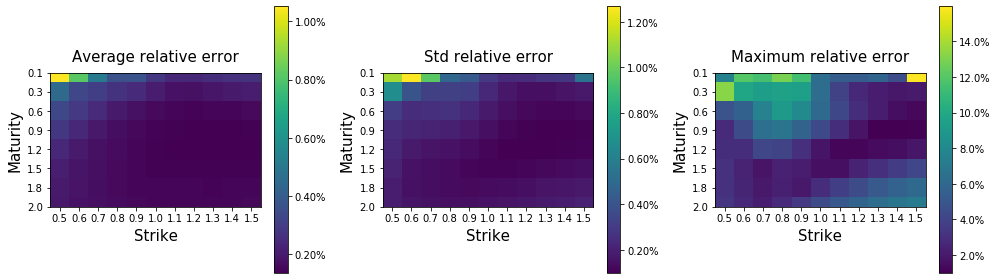

In [13]:
import numpy as np
import csv
S0=1.
strikes_dim=len(strikes)
maturities_dim=len(maturities)
strikeslabel=np.round(np.linspace(strikes[0],strikes[-1],8),1)
maturitieslabel=np.array([0.1,0.2, 0.6, 1.5,1.8])
##### AVERAGE VALUES #######
X_sample = xinversetransform(x_test_transform)
y_sample = y_test_transform

prediction=[xinversetransform(modelGEN.predict(y_sample[i].reshape(1,5))[0]) for i in range(len(y_sample))]
plt.figure(1,figsize=(14,4))
ax=plt.subplot(1,3,1)
err = np.mean(100*np.abs((X_sample-prediction)/X_sample),axis = 0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,2)
err = 100*np.std(np.abs((X_sample-prediction)/X_sample),axis = 0)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,3)
err = 100*np.max(np.abs((X_sample-prediction)/X_sample),axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
plt.tight_layout()
plt.savefig('HestonNNErrors.png', dpi=300)
plt.show()


# Plot sample Smiles

[ 0.01799103 -0.29271735  0.89585693  0.12036402  7.8141966 ]


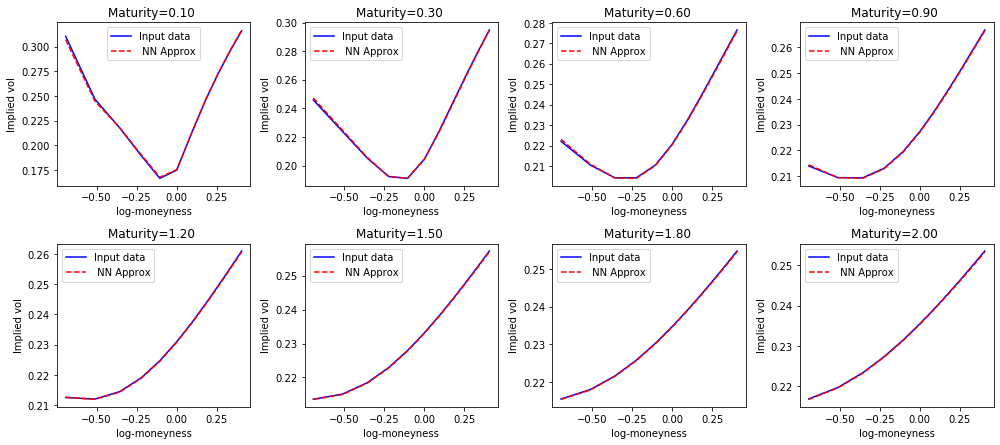

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import scipy
S0=1.

sample_ind = 1250
X_sample = X_test[sample_ind]
y_sample = y_test_transform[sample_ind]
print(scale.inverse_transform(y_sample))

prediction=xinversetransform(modelGEN.predict(y_sample.reshape(1,5))[0])
plt.figure(1,figsize=(14,12))
for i in range(maturities_dim):
    plt.subplot(4,4,i+1)
    
    plt.plot(np.log(strikes/S0),X_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
    plt.plot(np.log(strikes/S0),prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")

    
    plt.title("Maturity=%1.2f "%maturities[i])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")
    
    plt.legend()
plt.tight_layout()
plt.show()

# Use gradient methods for optimisation

In [15]:
def CostFunc(x,sample_ind):
    return np.sum(np.power((NeuralNetwork(x)-x_test_transform[sample_ind]),2))
def Jacobian(x,sample_ind):
    return 2*np.sum((NeuralNetwork(x)-x_test_transform[sample_ind])*NeuralNetworkGradient(x),axis=1)
#Cost Function for Levenberg Marquardt
def CostFuncLS(x,sample_ind):
    return (NeuralNetwork(x)-x_test_transform[sample_ind])
def JacobianLS(x,sample_ind):
    return NeuralNetworkGradient(x).T

In [16]:
import time
import scipy
Approx=[]
Timing=[]
sample_ind = 500
X_sample = X_test[sample_ind]
y_sample = y_test_transform[sample_ind]
solutions=np.zeros([4,5])
times=np.zeros(4)
init=np.zeros(5)
for i in range(1800):
    disp=str(i+1)+"/1800"
    print (disp,end="\r")
    #L-BFGS-B
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='L-BFGS-B',jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end= time.time()
    solutions[0,:]=myinverse(I.x)
    times[0]=end-start
    #SLSQP
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='SLSQP',jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end= time.time()
    solutions[1,:]=myinverse(I.x)
    times[1]=end-start
    #BFGS
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='BFGS',jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end= time.time()
    solutions[2,:]=myinverse(I.x)
    times[2]=end-start
    #Levenberg-Marquardt
    start= time.time()
    I=scipy.optimize.least_squares(CostFuncLS,init, JacobianLS,args=(i,),gtol=1E-10)
    end= time.time()
    solutions[3,:]=myinverse(I.x)
    times[3]=end-start
    
    Approx.append(np.copy(solutions))
    Timing.append(np.copy(times))

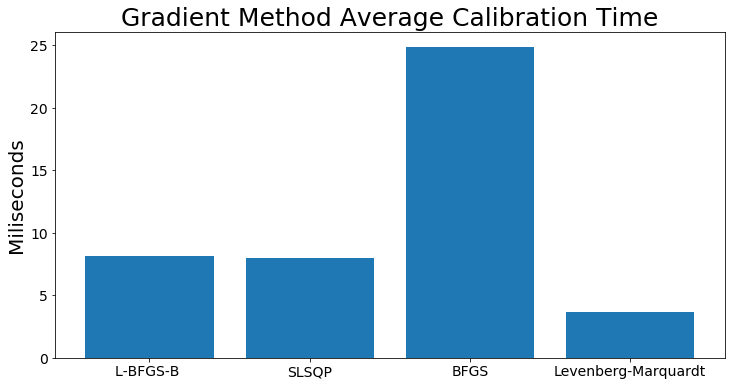

In [17]:
methods=["L-BFGS-B ","SLSQP","BFGS","Levenberg-Marquardt"]
plt.figure(1,figsize=(12,6))
plt.bar(methods,np.mean(Timing,axis=0)*1000)
plt.title("Gradient Method Average Calibration Time",fontsize=25)
plt.ylabel("Miliseconds",fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

# Save the Lavenberg-Marquardt Optimal parameters

In [18]:
LMParameters=[Approx[i][3] for i in range(len(Approx))]
np.savetxt("NNParametersHeston.txt",LMParameters)
LMParameters = np.loadtxt("NNParametersHeston.txt")

# Calibration Errors with Levenberg-Marquardt

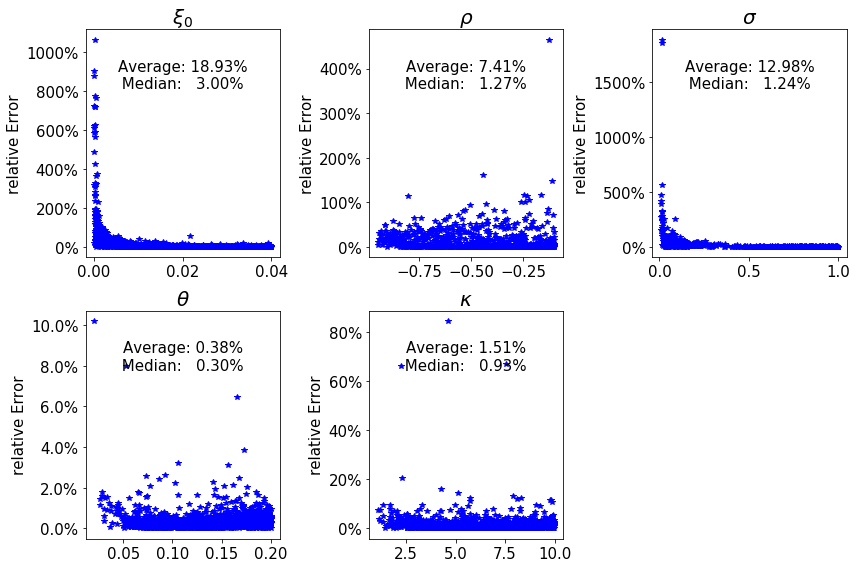

In [19]:
titles=["$\\xi_0$","$\\rho$","$\\sigma$","$\\theta$", "$\\kappa$"]
average=np.zeros([5,1800])
fig=plt.figure(figsize=(12,8))
for u in range(5):
    ax=plt.subplot(2,3,u+1)
    y=y_test[:1800,u]
    plt.plot(y,100*np.abs(LMParameters[:1800,u]-y)/np.abs(y),'b*')
    average[u,:]=np.abs(LMParameters[:1800,u]-y)/np.abs(y)
    
    plt.title(titles[u],fontsize=20)
    plt.ylabel('relative Error',fontsize=15)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.8, 'Average: %1.2f%%\n Median:   %1.2f%% '%(np.mean(100*average[u,:]),np.quantile(100*average[u,:],0.5)), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)
plt.tight_layout()

plt.savefig('HestonParameterRelativeErrors.png', dpi=300)
plt.show()

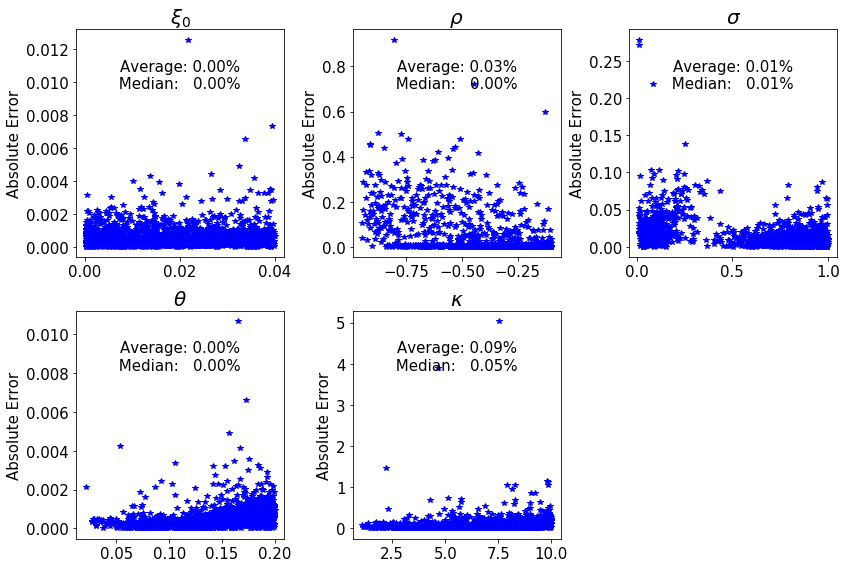

In [20]:
titles=["$\\xi_0$","$\\rho$","$\\sigma$","$\\theta$", "$\\kappa$"]
average=np.zeros([5,1800])
fig=plt.figure(figsize=(12,8))
for u in range(5):
    ax=plt.subplot(2,3,u+1)
    y=y_test[:1800,u]
    plt.plot(y,np.abs(LMParameters[:1800,u]-y),'b*')
    average[u,:]=np.abs(LMParameters[:1800,u]-y)
    
    plt.title(titles[u],fontsize=20)
    plt.ylabel('Absolute Error',fontsize=15)
    #plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.8, 'Average: %1.2f%%\n Median:   %1.2f%% '%(np.mean(average[u,:]),np.quantile(average[u,:],0.5)), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)
plt.tight_layout()

plt.savefig('HestonParameterAbsoluteErrors.png', dpi=300)
plt.show()